# to do
1. replace the root_dir and data_dir with path to training data if running on another CPU/GPU
2. change path to labels and images, and partition of train_files and var_files
3. build our own train_transformer and val_transformer, consider the effects of multimodal MRI
4. change cache dataset configurations and device name accordingly
5. which model should we use?

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


/home/yuexin/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

/home/yuexin/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


MONAI version: 1.4.dev2408
Numpy version: 1.24.3
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 39b752fefe096212bc7284786436c69d095c217e
MONAI __file__: /home/<username>/anaconda3/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.20.0
scipy version: 1.11.1
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.3
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.32.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, pl

In [1]:
# set up the root_dir and data_dir
directory = '/home/yuexin/Documents/MBP1413/'
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
data_dir = '/home/yuexin/Documents/MBP1413/'
print(data_dir)

/home/yuexin/Documents/MBP1413/
/home/yuexin/Documents/MBP1413/


In [33]:
train_images = sorted(glob.glob(os.path.join(data_dir, "MICCAI_BraTS2020_TrainingData", "BraTS20_Training_*", "*[!g].nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "MICCAI_BraTS2020_TrainingData", "BraTS20_Training_*", "*_seg.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[0:10], data_dicts[11:20]

In [34]:
print(f"training data: {train_files}")
print(f"validating data: {val_files}")

training data: [{'image': '/home/yuexin/Documents/MBP1413/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz', 'label': '/home/yuexin/Documents/MBP1413/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'}, {'image': '/home/yuexin/Documents/MBP1413/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz', 'label': '/home/yuexin/Documents/MBP1413/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii.gz'}, {'image': '/home/yuexin/Documents/MBP1413/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii.gz', 'label': '/home/yuexin/Documents/MBP1413/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii.gz'}, {'image': '/home/yuexin/Documents/MBP1413/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii.gz', 'label': '/home/yuexin/Documents/MBP1413/MICCAI_BraTS2020_TrainingData/BraTS20_Training_004/Br

In [35]:
set_determinism(seed=0)

In [111]:
# Define training transforms
# compose connect a series of transforms
train_transforms = Compose(
    [
        # Load image and label data
        LoadImaged(keys=["image", "label"]),
        # Ensure channel is the first dimension
        # pytorch work on tensor, batch x channel x height x width x depth
        EnsureChannelFirstd(keys=["image", "label"]),
        # Scale intensity values of the image within the specified range
        #ScaleIntensityRanged(
        #    keys=["image"],
        #    a_min=-57,
        #    a_max=164,
        #    b_min=0.0,
        #    b_max=1.0,
        #    clip=True,
        #),
        # Crop foreground from the image and label using the source image
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # Adjust the orientation of the image and label using RAS (Right, Anterior, Superior) axcodes
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Adjust the spacing of the image and label using specified pixel dimensions and interpolation modes
        # to make sure voxel size should be the same across all datasets
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        # Randomly crop regions with positive and negative labels to create training samples
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            # actual input size
            spatial_size=(60, 60, 60),
            # feature should be related to the foreground
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # Optionally, user can add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        # options: gaussian sharpening, random adjusting contrast
    ]
)

# Define validation transforms
val_transforms = Compose(
    [
        # Load image and label data
        LoadImaged(keys=["image", "label"]),
        # Ensure channel is the first dimension
        EnsureChannelFirstd(keys=["image", "label"]),
        # Scale intensity values of the image within the specified range
        #ScaleIntensityRanged(
        #    keys=["image"],
        #    a_min=-57,
        #    a_max=164,
        #    b_min=0.0,
        #    b_max=1.0,
        #    clip=True,
        #),
        # Crop foreground from the image and label using the source image
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # Adjust the orientation of the image and label using RAS (Right, Anterior, Superior) axcodes
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Adjust the spacing of the image and label using specified pixel dimensions and interpolation modes
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)


In [112]:
# Create a dataset using validation files and the specified validation transforms
check_ds = Dataset(data=val_files, transform=val_transforms)

# Create a DataLoader with a batch size of 1 for visualization purposes
check_loader = DataLoader(check_ds, batch_size=1)

# Retrieve the first batch of data from the DataLoader
check_data = first(check_loader)

# Extract the image and label from the data
image, label = (check_data["image"][0][0], check_data["label"][0][0])

# Print the shapes of the image and label
print(f"image shape: {image.shape}, label shape: {label.shape}")

image shape: torch.Size([86, 109, 68]), label shape: torch.Size([86, 109, 68])


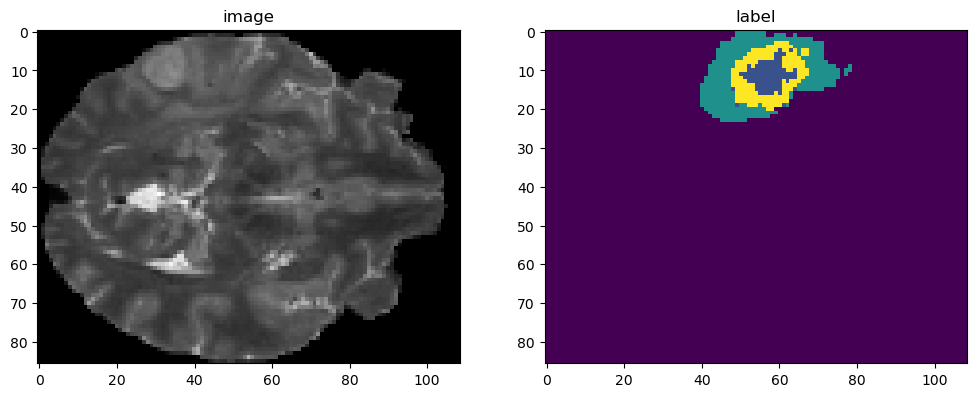

In [113]:
# Plot a slice of the images and labels (slice along the third dimension at index 30)
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30])
plt.show()

In [114]:
# Create a CacheDataset for training with accelerated caching
# CacheRate is set to 1.0, caching the entire dataset for optimal performance
# NumWorkers enables multi-threading during caching for faster data loading
# apply data augmentation in the compose until probability(?) is hit
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)

# Alternatively, for experimentation with the regular Dataset, uncomment the line below:
# train_ds = Dataset(data=train_files, transform=train_transforms)

# Use DataLoader to load training data in batches of size 2
# Shuffle the data for randomization and apply RandCropByPosNegLabeld for data augmentation
# Crop will create 4 samples
# The resulting batch size will be 2 x 4, generating 2 batches of 4 images each for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

# Create a CacheDataset for validation with accelerated caching
# Similar to training, CacheRate is set to 1.0, caching the entire dataset for optimal performance
# NumWorkers enables multi-threading during caching for faster data loading
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

# Alternatively, for experimentation with the regular Dataset, uncomment the line below:
# val_ds = Dataset(data=val_files, transform=val_transforms)

# Use DataLoader to load validation data in batches of size 1
# NumWorkers enables multi-threading during data loading for faster processing
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


In [116]:
device = torch.device("cpu")

for batch_data in train_loader:
    inputs, labels = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )
    print(f"Input image shape: {inputs.shape}") # should B x C X H X W X D
    print(f"Input label shape: {labels.shape}")
    break

Input image shape: torch.Size([8, 1, 60, 60, 60])
Input label shape: torch.Size([8, 1, 60, 60, 60])


In [117]:
# UNet and UNet R for segmentation
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    # channel kernel size
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
print(model)
# activation function add linearity

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
